# Segment nuclei and cells

In [3]:
import os
import bigfish
import bigfish.stack as stack
import bigfish.segmentation as segmentation
import bigfish.multistack as multistack
import bigfish.plot as plot
print("Big-FISH version: {0}".format(bigfish.__version__))

Big-FISH version: 0.6.2


In [4]:
# hard-code the paths of our input and output directories
path_input = "/data/smFISH/20251028_bartelle_smFISH_mm_microglia_newbuffers/qi2labdatastore/big_fish"
path_output = "/data/smFISH/20251028_bartelle_smFISH_mm_microglia_newbuffers/qi2labdatastore/big_fish"


In this notebook, we show examples of nucleus and cell segmentation. We perform segmentation in 2D. Some postprocessing can be applied on the masks to refine the results with a priori informations and constraints.

**Nucleus segmentation** can be performed using:
- A binarization of the dapi channel with a specific threshold.
- A prediction from a U-net based neural network.

**Cell segmentation** can be performed using:
- A watershed algorithm spread from the nuclei mask and directly applied on the image.
- A prediction from a U-net based neural network.

Additional ressources can be find online, especially the projects:
- [NucleAIzer](http://nucleaizer.org/)
- [Stardist](https://github.com/stardist/stardist/)
- [Cellpose](http://www.cellpose.org/)
- [EmbedSeg](https://github.com/juglab/EmbedSeg)

In [5]:
# path = os.path.join(path_input, "example_nuc_full.tif")
# nuc = stack.read_image(path)
# print("nucleus image")
# print("\r shape: {0}".format(nuc.shape))
# print("\r dtype: {0}".format(nuc.dtype), "\n")

path = os.path.join(path_input, "tile000bit004.ome.tiff")
cell = stack.read_image(path)
print("cell image")
print("\r shape: {0}".format(cell.shape))
print("\r dtype: {0}".format(cell.dtype))

cell image
 shape: (63, 2048, 2048)
 dtype: uint16


## Nuclei segmentation

### Thresholding

**Thresholding** is performed in three steps:  
- A simple tresholding is applied using `bigfish.segmentation.thresholding` function on a 2D image to obtain a binary mask.  
- The mask is processed with `bigfish.segmentation.clean_segmentation` to remove binary artefacts (small objects, holes).  
- Different nuclei instances are labelled with `bigfish.segmentation.label_instances`.

In [5]:
# thresholding
nuc_mask = segmentation.thresholding(nuc, threshold=500)
nuc_mask = segmentation.clean_segmentation(nuc_mask, small_object_size=2000, fill_holes=True)
print("nuclei mask")
print("\r shape: {0}".format(nuc_mask.shape))
print("\r dtype: {0}".format(nuc_mask.dtype), "\n")

# labeling
nuc_label = segmentation.label_instances(nuc_mask)
print("nucleus labels")
print("\r shape: {0}".format(nuc_label.shape))
print("\r dtype: {0}".format(nuc_label.dtype))

nuclei mask
 shape: (2160, 2160)
 dtype: bool 

nucleus labels
 shape: (2160, 2160)
 dtype: int64


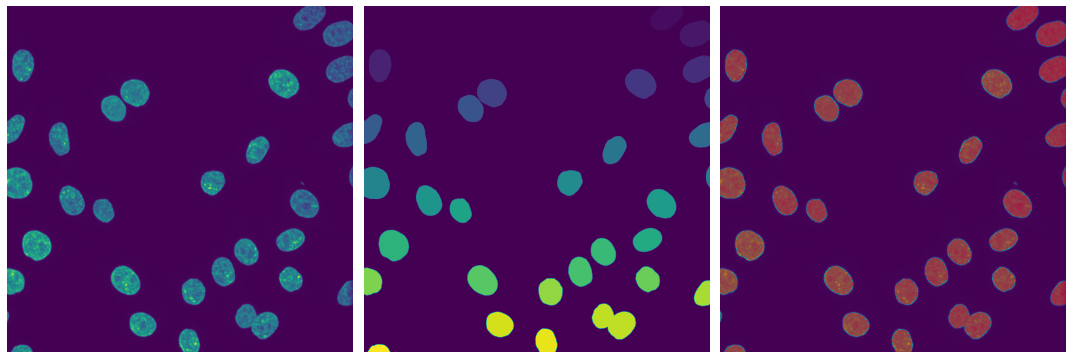

In [5]:
plot.plot_segmentation(nuc, nuc_label, rescale=True)

### U-net based model

We implement a U-net based model to directly segment nucleus. It could be particularly usefull to discriminate adjacent nuclei. 

The big-fish implementation of U-net requires _tensorflow_ and _tensorflow-addons_ packages. Skip this step if you don't have tensorflow installed or if you don't need to use this algorithm. 

Segmentation is performed in two steps:
- A pretrained model is loaded with `bigfish.segmentation.unet_3_classes_nuc`.
- The model is applied with `bigfish.segmentation.apply_unet_3_classes`. It predicts 3 classes in the image - foreground, background and nucleus boundary. From this prediction, a mask is built for each nucleus instance.

In [6]:
# Check deep learning packages are installed and print their version
import tensorflow as tf
import tensorflow_addons as tfa
print(tf.__version__)
print(tfa.__version__) 

2.6.0
0.14.0


In [7]:
# load pretrained model
model_nuc = segmentation.unet_3_classes_nuc()
model_nuc.summary()

TypeError: Parameter to MergeFrom() must be instance of same class: expected tensorflow.TensorShapeProto got tensorflow.TensorShapeProto.

In [10]:
# instance segmentation
nuc_label = segmentation.apply_unet_3_classes(
    model_nuc, nuc, target_size=256, test_time_augmentation=True)
print("nucleus labels")
print("\r shape: {0}".format(nuc_label.shape))
print("\r dtype: {0}".format(nuc_label.dtype))

NameError: name 'model_nuc' is not defined

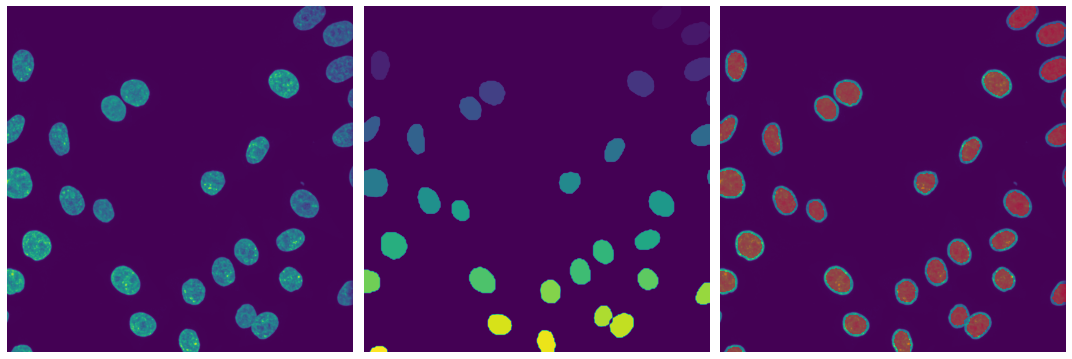

In [9]:
plot.plot_segmentation(nuc, nuc_label, rescale=True)

## Cells segmentation

### Watershed

In a **watershed** algorithm (`bigfish.segmentation.cell_watershed`) we consider cells as watershed to be flooded. The **watershed relief** is inversely proportional to both the **pixel intensity** and the **closeness to nuclei**. Pixels with a high intensity or close to labelled nuclei have a low watershed relief value. They will be flooded in priority. Flooding the watersheds allows to propagate nuclei labels through potential cytoplasm areas. The lines separating watershed are the final segmentation of the cells.

In [11]:
# apply watershed
cell_label = segmentation.cell_watershed(cell, nuc_label, threshold=500, alpha=0.9)
print("cell labels")
print("\r shape: {0}".format(cell_label.shape))
print("\r dtype: {0}".format(cell_label.dtype))

cell labels
 shape: (2160, 2160)
 dtype: int64


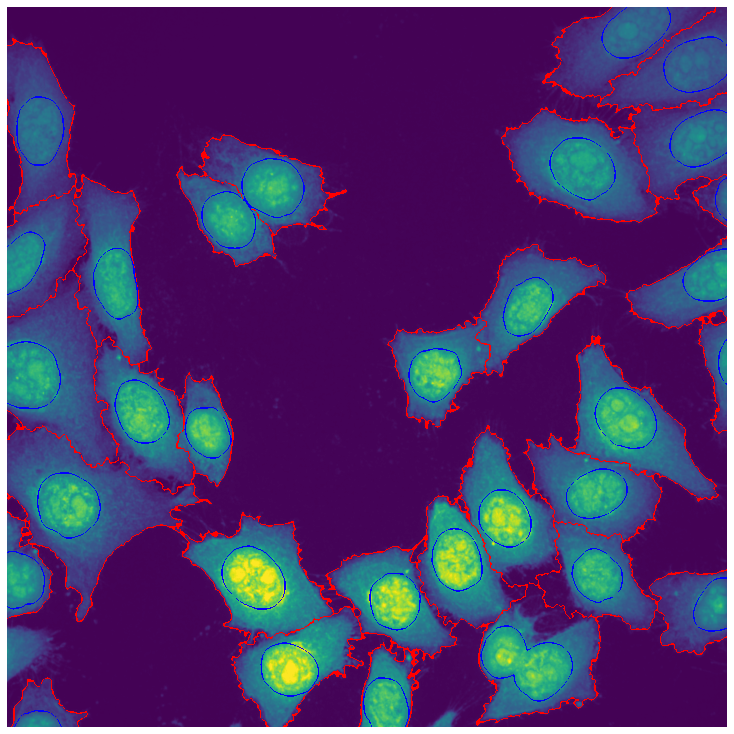

In [12]:
plot.plot_segmentation_boundary(cell, cell_label, nuc_label, contrast=True, boundary_size=4)

The previous steps can be computed separately. The **watershed algorithm** itself (`bigfish.segmentation.apply_watershed`) needs three elements:
- **Markers** to start the flood (the labelled nuclei).
- A **watershed relief** to drive the flood (`bigfish.segmentation.get_watershed_relief`).
- A **mask** to delimit the flooding area (any binary segmentation of the cells).

In [13]:
# build watershed representation of the cells
watershed_relief = segmentation.get_watershed_relief(cell, nuc_label, alpha=0.9)
print("watershed relief")
print("\r shape: {0}".format(watershed_relief.shape))
print("\r dtype: {0}".format(watershed_relief.dtype), "\n")

# build cell mask
cell_mask = segmentation.thresholding(cell, threshold=500)
cell_mask[nuc_label > 0] = True
cell_mask = segmentation.clean_segmentation(cell_mask, 
                                            small_object_size=5000, 
                                            fill_holes=True)
print("cell mask")
print("\r shape: {0}".format(cell_mask.shape))
print("\r dtype: {0}".format(cell_mask.dtype), "\n")

# apply watershed algorithm
cell_label = segmentation.apply_watershed(watershed_relief, nuc_label, cell_mask)
print("cell labels")
print("\r shape: {0}".format(cell_label.shape))
print("\r dtype: {0}".format(cell_label.dtype))

watershed relief
 shape: (2160, 2160)
 dtype: uint16 

cell mask
 shape: (2160, 2160)
 dtype: bool 

cell labels
 shape: (2160, 2160)
 dtype: int64


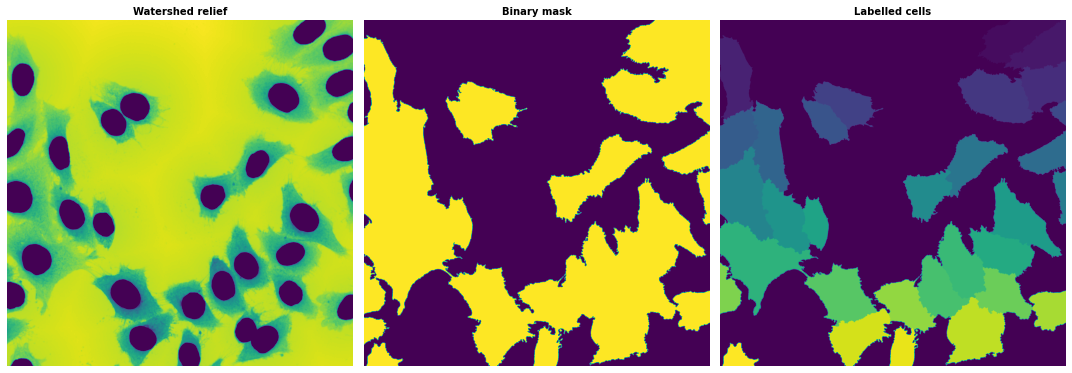

In [14]:
plot.plot_images([watershed_relief, cell_mask, cell_label], 
                 titles=["Watershed relief", "Binary mask", "Labelled cells"])

### U-net based model

We implement a U-net based model to directly segment cells. It could be particularly usefull to discriminate adjacent cells or segment uneven illuminated images. 

The big-fish implementation of U-net requires _tensorflow_ and _tensorflow-addons_ packages. Skip this step if you don't have tensorflow installed or if you don't need to use this algorithm. 

Segmentation is also performed in two steps:
- A pretrained model is loaded with `bigfish.segmentation.unet_distance_edge_double`.
- The model is applied with `bigfish.segmentation.apply_unet_distance_double`. It predicts a distance map that will be processed through a watershed algorithm. This model takes two images as input - a nucleus and a cell channel. In addition it requires an estimation of the nucleus labels to be used as a seed for the watershed algorithm.

In [15]:
# Check deep learning packages are installed and print their version
import tensorflow as tf
import tensorflow_addons as tfa
print(tf.__version__)
print(tfa.__version__) 

2.6.0
0.14.0


In [16]:
model_cell = segmentation.unet_distance_edge_double()
model_cell.summary()

TypeError: Parameter to MergeFrom() must be instance of same class: expected tensorflow.TensorShapeProto got tensorflow.TensorShapeProto.

In [17]:
# instance segmentation
cell_label = segmentation.apply_unet_distance_double(
    model_cell, 
    nuc=nuc, 
    cell=cell, 
    nuc_label=nuc_label, 
    target_size=256, test_time_augmentation=True)
print("cell labels")
print("\r shape: {0}".format(cell_label.shape))
print("\r dtype: {0}".format(cell_label.dtype))

NameError: name 'model_cell' is not defined

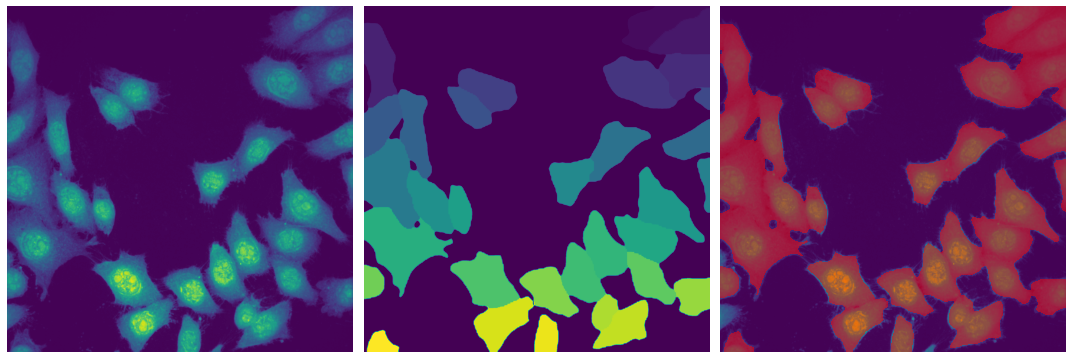

In [17]:
plot.plot_segmentation(cell, cell_label, rescale=True)

## Post processing

Additional cleaning functions can be applied in the labels with `bigfish.segmentation.clean_segmentation` to smooth the segmented boundaries or properly delimit the different instances.

In [18]:
nuc_label = segmentation.clean_segmentation(nuc_label, delimit_instance=True)
cell_label = segmentation.clean_segmentation(cell_label, smoothness=7, delimit_instance=True)
nuc_label, cell_label = multistack.match_nuc_cell(nuc_label, cell_label, single_nuc=False, cell_alone=True)

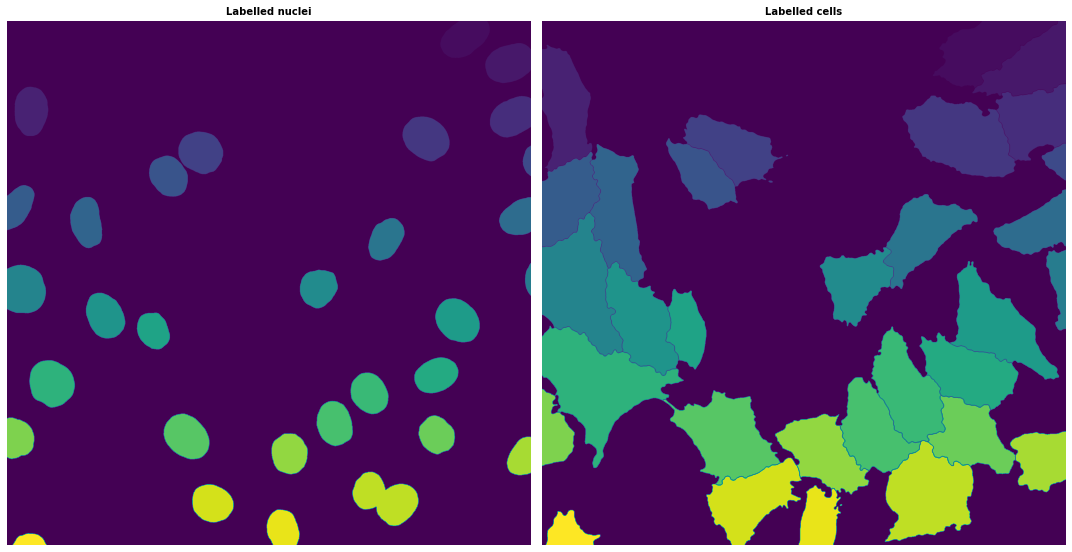

In [19]:
plot.plot_images([nuc_label, cell_label], titles=["Labelled nuclei", "Labelled cells"])

## Save results

Masks are binary images saved in **png files**. Labelled instances are integer images. A **tif file** should be prefered to ensure dtype consistency. Both methods are possible with `bigfish.stack.save_image`.

dapi channel
 shape: (23, 650, 500)
 dtype: uint16 

smfish channel
 shape: (23, 650, 500)
 dtype: uint16


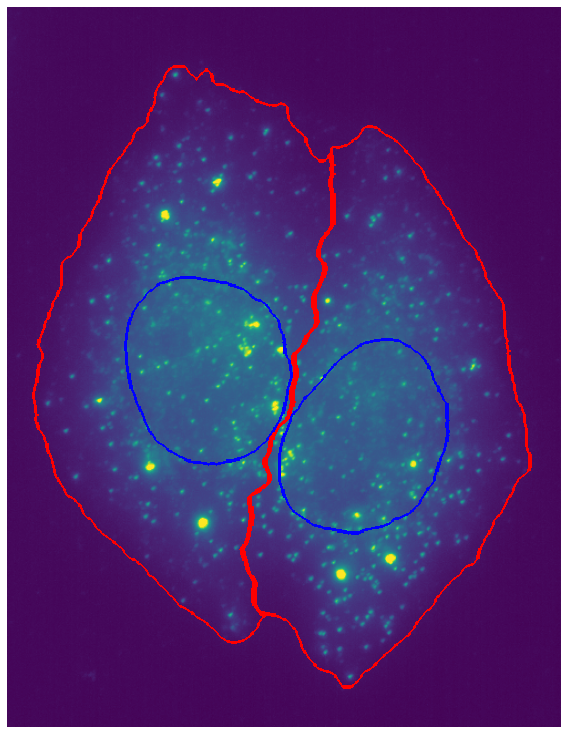

In [20]:
# read dapi image
path = os.path.join(path_input, "experiment_1_dapi_fov_1.tif")
nuc = stack.read_image(path)
print("dapi channel")
print("\r shape: {0}".format(nuc.shape))
print("\r dtype: {0}".format(nuc.dtype), "\n")
nuc_2d = stack.maximum_projection(nuc)

# read smfish image
path = os.path.join(path_input, "experiment_1_smfish_fov_1.tif")
rna = stack.read_image(path)
print("smfish channel")
print("\r shape: {0}".format(rna.shape))
print("\r dtype: {0}".format(rna.dtype))
rna_2d = stack.maximum_projection(rna)

# nucleus segmentation
nuc_mask = segmentation.thresholding(nuc_2d, threshold=27000)
nuc_mask = segmentation.clean_segmentation(nuc_mask, small_object_size=2000, fill_holes=True)
nuc_label = segmentation.label_instances(nuc_mask)

# cell segmentation
cell_label = segmentation.cell_watershed(rna_2d, nuc_label, threshold=4800, alpha=0.9)

# postprocessing
nuc_label = segmentation.clean_segmentation(nuc_label, delimit_instance=True)
cell_label = segmentation.clean_segmentation(cell_label, smoothness=7, delimit_instance=True)
nuc_label, cell_label = multistack.match_nuc_cell(nuc_label, cell_label, single_nuc=False, cell_alone=True)

# plot
plot.plot_segmentation_boundary(rna_2d, cell_label, nuc_label, contrast=True)

# save nucleus and cell labels
path = os.path.join(path_output, "nuc_label.tif")
stack.save_image(nuc_label, path)
path = os.path.join(path_output, "cell_label.tif")
stack.save_image(cell_label, path)